## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
len(df[df['converted'] == 1])/len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
len(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False])

3893

f. Do any of the rows have missing values?

In [7]:
df.loc[df.isnull().any(axis=1)] # No missing values

,user_id,timestamp,group,landing_page,converted


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.loc[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.loc[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates('user_id')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2_control_mean = df2.loc[df2['group'] == 'control']['converted'].mean()
df2_control_mean

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2_treatment_mean = df2.loc[df2['group'] == 'treatment']['converted'].mean()
df2_treatment_mean

0.11880806551510564

In [17]:
obs_diff = df2_treatment_mean - df2_control_mean
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [18]:
len(df2.loc[df2['landing_page'] == 'new_page'])/len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> Before conducting any statistical analysis, given the similar conversion rates between the entire population, the control population, and the treatment population, there does not seem to be any evidence that the treatment page leads to more conversions. In fact, it appears to lead to slightly less conversions (0.1188 vs. 0.1204).

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> $H_0: p_{old} - p_{new} \geq 0$
>
> $H_1: p_{old} - p_{new} < 0$
>
>
> $p_{old}$ and $p_{new}$ are the conversion rates for the old and new pages, respectively.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = len(df2.loc[df2['landing_page'] == 'new_page'])
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = len(df2.loc[df2['landing_page'] == 'old_page'])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11864978322207693

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.11945014248936492

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
diff_p = new_page_converted.mean() - old_page_converted.mean()
diff_p

-0.0008003592672879839

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
new_conv_sim = np.random.binomial(n_new, p_new, 10000)/n_new
old_conv_sim = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_conv_sim - old_conv_sim

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

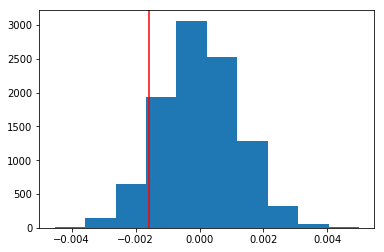

In [27]:
plt.hist(p_diffs);

plt.axvline(obs_diff, c='red');

> This plot is normally distributed at 0, which makes sense given the small observed difference in the conversion rates between the new and old pages.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs > obs_diff).mean()

0.9078

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> 0.9 is the p-value. This describes the proportion of values in the null distribution that are greater than the observed difference. P-values help determine the significance of results. A p-value less than or equal to alpha indicates strong evidence to reject the null. A p-value greater than alpha indicates weak evidence against the null hypothesis.
>
> Because the p-value is much greater than alpha in this case, we fail to reject the null and conclude that the website should keep the current page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

# number of old page converters
convert_old = len(df2.loc[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)])
# number of new page converters
convert_new = len(df2.loc[(df2['landing_page'] == 'new_page') & (df2['converted'] == 1)])
# number of individuals who received the old page
n_old = len(df2.loc[df2['landing_page'] == 'old_page'])
# number of individuals who received the new page
n_new = len(df2.loc[df2['landing_page'] == 'new_page'])

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
# Alternative = 'larger' indicates that alternative hypothesis is p_new > p_old, consistent with our previous test.
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')

In [31]:
z_score

-1.3109241984234394

In [32]:
p_value

0.9050583127590245

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> 0.9 is the p-value. This is consistent with the p-value from parts j and carries the same significance as the results from part k.
>
> The z-score or standard score is the number of standard deviations by which the observed value is above the mean value. The critical z‐score for alpha = 0.05 in the upper tail is 1.65. Because the magnitude of the z-score (1.31) is less than 1.65, we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> Logistic regression bounds our response to a probability between 0 and 1. This is appropriate in a binomial conversion/no conversion situation such as this one.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept'] = 1
df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['drop'], axis=1, inplace=True)
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
# statsmodel.api was imported as sm earlier
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:11:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> The p-value associated with this regression model is 0.2, which is different from the 0.9 p-values calculated manually or with the null hypothesis.
>
> The difference in p-values stems from the fact that the null hypothesis for logistic regression is that there is no relationship between variables. This is different that the null hypotheses in part 2, that claimed the average conversion rate for users that received the new page is less than or equal to the average conversion rate for users that received the old page.
>
> With different hypotheses in question, the p-values would expectedly be different.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> Considering additional factors can reveal insights that may not been revealed initially. A user's age, location, time spent on the page, etc. may be important to consider in determining if implementing the new page may be advantageous in certain scenarios. However, complex datasets that examine multiple variables are more susceptible to false conclusions if not analyzed properly. Multicollinearity can occur when variables are related to each other and not the response, causing potentially unstable relationships and correlation coefficients. Incomplete data or varying dataset sizes may also prove to be difficult when incorporating them into a multivariable regression model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
# Join on 'user_id'
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [37]:
# Create dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1


In [38]:
# Create summary of country multivariable regression model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results_new = log_mod.fit()
results_new.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 19 Dec 2018   Pseudo R-squ.:               2.323e-05
Time:                        12:12:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [39]:
# The way dummy variables are encoded in logistic regression is the 
# same as multi-linear regression, so interpreting the dummy variable 
# coefficents is only changed again by exponentiating the coefficient.

np.exp(results_new.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

> Canada serves as the baseline for this model. Looking under the 'coef' column of the summary, US users are 4% more likely to convert than Canadian users (holding all other variables constant) and UK users are 5% more likely to convert than Canadian users (holding all other variables constant).

> Given the large p-values and small difference bwetween country conversion rates, these results are not statistically or practically significant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
# Create new columns for each country specific to users that saw the new page
df_new['new_CA'] = df_new['ab_page'] * df_new['CA']
df_new['new_US'] = df_new['ab_page'] * df_new['US']
df_new['new_UK'] = df_new['ab_page'] * df_new['UK']
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,new_CA,new_US,new_UK
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,0


In [41]:
# Create summary of country & new page multivariable regression model
log_mod_new = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'new_US', 'new_UK']])
results_log_new = log_mod_new.fit()
results_log_new.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 19 Dec 2018   Pseudo R-squ.:               3.351e-05
Time:                        12:13:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0827      0.038     -2.176      0.030      -0.157      -0.008
new_US         0.0644      0.038      1.679      0.093      -0.011       0.140
new_UK         0.0901      0.040      2.225      0.026       0.011       0.169
==============================================================================
"""

In [42]:
np.exp(results_log_new.params)

intercept    0.136863
ab_page      0.920649
new_US       1.066532
new_UK       1.094247
dtype: float64

> It appears the only variable that becomes significant when country & page interaction is considered is the UK with a small p-value of 0.026. This means that UK users shown the new page are 9% more likely to convert than Canadian users. However, this is not practically significant. Comparing Canada's low conversion rate to a page specific conversion rate of the highest converting country is essentially cherry-picking for significance. It doesn't make sense for the company to implement a specific page in one country just becasue it leads to a statistically higher rate of conversions than the least converting country.